<a href="https://colab.research.google.com/github/demelere/Text-Classification/blob/master/453_Assignment_3_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [44]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
qualitative_colors=sns.set_palette("Set3",10)
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# word vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# model pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Data input and cleaning

In [0]:
df = pd.read_csv('bbc-text.csv')

SHAPE OF DATASET:  (2225, 2) 

COLUMNS IN DATASET:  Index(['category', 'text'], dtype='object') 

CATEGORIES:  ['tech' 'business' 'sport' 'entertainment' 'politics'] 

DATA SAMPLE: 

       category                                               text
384   politics  drive to  save  festive holidays efforts are b...
1983     sport  officials respond in court row australian tenn...
985      sport  cup holders man utd visit everton holders manc...
1386     sport  adriano s chelsea link rejected adriano s agen...
1294     sport  o driscoll/gregan lead aid stars ireland s bri... 


NUMBER OF SAMPLES IN EACH CATEGORY: 



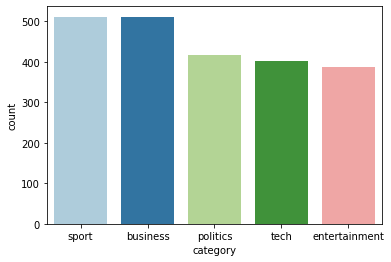

In [46]:
# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, '\n\nCOLUMNS IN DATASET: ', df.columns, '\n\nCATEGORIES: ', df.category.unique(), '\n\nDATA SAMPLE: \n\n', df.sample(n=5, random_state=0), '\n\n')

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(x=df.category, order=df.category.value_counts().index,color=sns.set_palette("Paired"))

In [0]:
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [48]:
# DATA CLEANING
print('Data cleaning in progress...')

# Tokenize
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Data cleaning in progress...
Tokenization complete.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization complete.
Data cleaning complete.



# 3. Model training and evaluation

## 3.1 Classification using Word2Vec Vectors

In [0]:
vec_model = Word2Vec(df['text_clean'])
w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

In [0]:
# clf_models = {
#     'Logistic Regression': LogisticRegression(),
#     'Random Forest': RandomForestClassifier(),
#     'Naive Bayes': GaussianNB(), 
#     'SVC': SVC(),
#     'Decision Tree': DecisionTreeClassifier(),  
#     'Perceptron': MLPClassifier(),
#     'Gradient Boosting': GradientBoostingClassifier()
# }

# clf_params = {
#     'Logistic Regression': { },
#     'Random Forest': { },
#     'Naive Bayes': { }, 
#     'SVC': { 'kernel': ['linear', 'rbf'] },
#     'Decision Tree': { 'min_samples_split': [2, 5] }, 
#     'Perceptron': { 'activation': ['tanh', 'relu'] },
#     'Gradient Boosting': { 'min_samples_split': [2, 5] }
# }

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

# for key in clf_models.keys():
    
#     clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
    
#     print(key, ':')
#     print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))

## 3.2 Classification using TF-IDF Vectors

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(2225, 14415)

In [53]:
models = [
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(min_samples_split=[2, 5]),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    GaussianNB(),
    GradientBoostingClassifier(),
    SVC(kernel=['linear', 'rbf']),

]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

KeyboardInterrupt: ignored